In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [190]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip



from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily, CountMinSketchHadamard, CountMinSketchLocalHashing
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, query_df, infer_domains_and_ranges

# set_style()

In [125]:
delta = 0.05
abs_error_eps = 1.0

# Online Retail

In [126]:
retail_df = pd.read_parquet("../data/clean/online_retail.parquet")

In [127]:
query_path = "../queries/online_retail_2_cols.json"
with open(query_path, 'rb') as f:
    queries = orjson.loads(f.read())

ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")


In [184]:
p_sketch = PachaSketch.build_with_uniform_size(
    levels=5,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01))
p_sketch.get_size()

95.50641822814941

In [185]:
p_sketch.update_data_frame(retail_df, workers=os.cpu_count())

Updating: 100%|██████████| 541909/541909 [07:51<00:00, 1149.57it/s]


In [188]:
p_sketch.save_to_file("../sketches/real_world/online_retail_uniform_3.json.gz")

In [191]:
p_sketch2 = PachaSketch.from_json("../sketches/real_world/online_retail_uniform_3.json.gz")

In [142]:
p_sketch2 == p_sketch

True

In [62]:
details

{'cat_regions': 125,
 'num_regions': 947,
 'query_regions': 15630,
 'queries_per_level': [534, 2000, 3147, 9949, 0]}

In [63]:
def evaluate_queries(df: pd.DataFrame, queries: list, p_sketch: PachaSketch, path_to_file: str = None):
    print("Computing true counts...")
    true_counts = []
    for query in tqdm(queries, desc="True Count"):
        true_counts.append(query_df(df, query))
    true_counts = np.asarray(true_counts)
    
    print("Computing estimates...")
    estimates = []
    cat_regions = []
    num_regions = []
    query_regions = []
    level_queries = []
    for i in range(p_sketch.levels):
        level_queries.append([])
    for query in tqdm(queries, desc="Estimates"):
        est, details = p_sketch.query(query, detailed=True)
        estimates.append(est)
        cat_regions.append(details["cat_regions"])
        num_regions.append(details["num_regions"])
        query_regions.append(details["query_regions"])
        for i, n_queries in enumerate(details["queries_per_level"]):
             level_queries[i].append(n_queries)
    
    measurements = {
        "true_counts": true_counts,
        "estimates": estimates,
        "cat_regions": cat_regions,
        "num_regions": num_regions,
        "query_regions": query_regions
    }

    for i, level_i in enumerate(level_queries):
        measurements[f"level_{i}_queries"] = level_i

    results_df = pd.DataFrame(measurements)

    if path_to_file is not None:
        results_df.to_csv(path_to_file, index=False)

    return results_df


In [ ]:
results_df = evaluate_queries(retail_df, queries["queries"], p_sketch2, path_to_file="../results/real_world/online_retail_p_sketch_uniform.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 44.22it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [21:25<00:00,  6.43s/it] 


In [195]:
absolute_error = np.abs(results_df["true_counts"].to_numpy() - results_df["estimates"].to_numpy())

In [205]:
np.sum((results_df["true_counts"] - results_df["estimates"]) < 0)

84

In [ ]:
print("Mean absolute error:", np.mean(absolute_error))
print("Max absolute error:", np.max(absolute_error))
print("Min absolute error:", np.min(absolute_error))
results_df["absolute_error"] = absolute_error
results_df["absolute_error"].describe()


Mean absolute error: 12248.885
Max absolute error: 79444
Min absolute error: 27


count      200.0000
mean     12248.8850
std      21366.2683
min         27.0000
25%        336.0000
50%       1706.5000
75%      11692.0000
max      79444.0000
Name: absolute_error, dtype: float64

In [197]:
results_df["relative_error"] = results_df["absolute_error"] / len(retail_df)
results_df["relative_error"].describe()

count    200.000000
mean       0.022603
std        0.039428
min        0.000050
25%        0.000620
50%        0.003149
75%        0.021576
max        0.146600
Name: relative_error, dtype: float64

In [200]:
results_df.to_csv("../results/real_world/online_retail_p_sketch_uniform.csv", index=False)

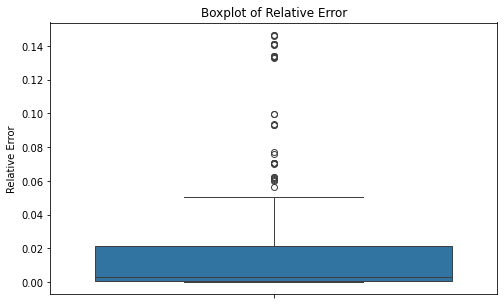

In [198]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=results_df["relative_error"])
plt.ylabel("Relative Error")
plt.title("Boxplot of Relative Error")
plt.show()

In [ ]:


def check_accruracy(sketch, df, query_regions, level):
    query_regions_level = [region for region in query_regions if region[1].level == level]
    estimates = []
    print("Estimating with sketch...")
    for region in tqdm(query_regions_level, desc="Sketch Query"):
        num_region = region[1]
        estimates.append(sketch.base_sketches[num_region.level].query(region))
    estimates = np.asarray(estimates)

    true_counts = []
    print("Computing true counts...")
    for region in tqdm(query_regions_level, desc="True Count"):
        true_counts.append(query_df(df, translate_query_region(region)))
    true_counts = np.asarray(true_counts)

    abs_errors = np.abs(estimates - true_counts)
    rel_errors = abs_errors / len(df)

    print(f"Level {level}")
    print(f"Mean Abs Error: {np.mean(abs_errors)}, Mean Rel Error: {np.mean(rel_errors)}")
    print(f"Max Abs Error: {np.max(abs_errors)}, Max Rel Error: {np.max(rel_errors)}")
    print(f"Min Abs Error: {np.min(abs_errors)}, Min Rel Error: {np.min(rel_errors)}")
    print(f"Correct estimates: {np.sum(abs_errors == 0)}")

    return estimates, true_counts, abs_errors, rel_errors

In [230]:
estimates, true_counts, abs_errors, rel_errors = check_accruracy(p_sketch1, retail_df, query_regions, 3)

Estimating with sketch...


Sketch Query:   0%|          | 0/10972 [00:00<?, ?it/s]

Sketch Query: 100%|██████████| 10972/10972 [00:00<00:00, 65984.69it/s]


Computing true counts...


True Count: 100%|██████████| 10972/10972 [09:07<00:00, 20.05it/s]

Level 3
Mean Abs Error: 0.12850893182646736, Mean Rel Error: 2.371411654474596e-07
Max Abs Error: 199, Max Rel Error: 0.0003672203266600112
Min Abs Error: 0, Min Rel Error: 0.0
Correct estimates: 10725


In [250]:
estimates, true_counts, abs_errors, rel_errors = check_accruracy(p_sketch1, retail_df, query_regions, 0)

Estimating with sketch...


Sketch Query: 100%|██████████| 1630/1630 [00:00<00:00, 7675.61it/s]


Computing true counts...


True Count: 100%|██████████| 1630/1630 [01:18<00:00, 20.73it/s]

Level 0
Mean Abs Error: 0.12699386503067484, Mean Rel Error: 2.3434536985116476e-07
Max Abs Error: 8, Max Rel Error: 1.4762626197387384e-05
Min Abs Error: 0, Min Rel Error: 0.0
Correct estimates: 1501


In [239]:
query_regions_level_3_cat = [region[0] for region in query_regions if region[1].level == 3]

In [242]:
counter =  Counter(query_regions_level_3_cat).items()

In [243]:
counter

dict_items([(('238', 'United Kingdom', '*'), 15), (('825', 'United Kingdom', '*'), 111), (('237', 'United Kingdom', '*'), 15), (('852', 'United Kingdom', '*'), 105), (('851', 'United Kingdom', '*'), 169), (('826', 'United Kingdom', '*'), 79), (('PAD', 'United Kingdom', '*'), 12), (('901', 'United Kingdom', '*'), 93), (('793', 'United Kingdom', '*'), 64), (('902', 'United Kingdom', '*'), 55), (('222', 'United Kingdom', '*'), 173), (('160', 'United Kingdom', '*'), 62), (('842', 'United Kingdom', '*'), 90), (('213', 'United Kingdom', '*'), 161), (('843', 'United Kingdom', '*'), 135), (('216', 'United Kingdom', '*'), 164), (('819', 'United Kingdom', '*'), 13), (('711', 'United Kingdom', '*'), 20), (('218', 'United Kingdom', '*'), 177), (('DCG', 'United Kingdom', '*'), 16), (('354', 'United Kingdom', '*'), 42), (('771', 'United Kingdom', '*'), 16), (('233', 'United Kingdom', '*'), 178), (('727', 'United Kingdom', '*'), 103), (('212', 'United Kingdom', '*'), 165), (('214', 'United Kingdom', 

In [235]:
query_regions_level_3 = [region for region in query_regions if region[1].level == 3]

In [236]:
idx = np.argmax(abs_errors)
print(f"Query: {query_regions_level_3[idx]}")
print(f"Estimate: {estimates[idx]}")
print(f"True Count: {true_counts[idx]}")

Query: (('216', 'United Kingdom', '*'), <lib.encoders.BAdicCube object at 0x75db65f73ef0>)
Estimate: 203
True Count: 4


In [ ]:
def query_subregion(sketch, query_regions, level):
    query_regions_level = [region for region in query_regions if region[1].level == level]
    results = []
    for region in query_regions_level:
        num_region = region[1]
        results.append(sketch.base_sketches[num_region.level].query(region))
    return np.asarray(results)

In [140]:
results_0 = query_subregion(p_sketch1, query_regions, level=0)

In [147]:
np.asarray(p_sketch.max_values)

array([   304,     71, 168469])

In [148]:
abs_error_eps / (len(retail_df) * 10)

1.845328274673423e-07

In [150]:
level_results_3 = query_subregion(p_sketch1, query_regions, level=3)

In [154]:
level_results_3.max()

np.int64(203)

In [59]:
est, details = p_sketch2.query(queries["queries"][0], detailed=True)

In [32]:
test_bf = BFParameters(n_values=100, p=0.01).build_sketch()
test_bf.update("test")
test_bf.query("test")


True

In [192]:
est, details = p_sketch2.query(queries["queries"][1], debug=True, detailed=True)

Categorical regions: 1
Indexed categorical regions: 1
Numerical regions: 239442
Indexed numerical regions: 3363
Candidate regions: 3363
Query regions: 690
Level 0 queries: 105
Level 1 queries: 313
Level 2 queries: 120
Level 3 queries: 152
Estimate: 3082


In [164]:
est, details = p_sketch2.query(queries["queries"][1], debug=True, detailed=True)

Categorical regions: 1
Indexed categorical regions: 1
Numerical regions: 745228
Indexed numerical regions: 3363
Candidate regions: 3363
Query regions: 690
Level 0 queries: 105
Level 1 queries: 313
Level 2 queries: 120
Level 3 queries: 152
Estimate: 3082


In [168]:
r = BAdicRange(2,2,2)
d = {}
d[(r,1)] = 1
r2 = BAdicRange(2,2,2)
d[(r2,1)]

1

In [173]:
(r2,2) in d

False

In [175]:
queries["queries"][1]

[['226'], '*', '*', [93, 170], '*', '*']

In [180]:
true_result = query_df(retail_df, queries["queries"][1])

In [145]:
np.abs(true_result - est) / len(retail_df)

0.00727243873048796

In [181]:
true_result

7023

In [13]:
est

123575

In [147]:
for bm in p_sketch2.numerical_bitmaps:
    print(bm.exponent)

0
0
5


In [155]:
p_sketch2.max_values

[304, 71, 168469]

In [157]:
total = len(retail_df["age"].unique())
correct = 0
for v in retail_df["age"].unique():
    if p_sketch2.numerical_bitmaps[0].query(v):
        correct += 1
print(correct / total)

1.0


In [149]:
np.sum(p_sketch2.numerical_bitmaps[2].positive_bitmap)

151

In [116]:
a, b = test1()
c = test1()

In [119]:
c

(1, None)